# Lab 5: Species Distribution Modeling with Bagging 
Climate change and deforestation are accelerating ecosystem degradation, pushing animal species toward the brink of extinction. Understanding the distribution of animals and the factors that influence their ability to thrive in different environments is critical for conservation efforts. By studying these relationships, biological conservationists can develop informed strategies to protect endangered species and maintain biodiversity across diverse ecosystems.

Species are defined by their behavioral, physiological, and ecological attributes, which shape their roles in ecosystems. In turn, ecosystems and their functions are deeply influenced by the species that inhabit them. This reciprocal relationship makes evaluating species' functional diversity and distributions essential for research in biogeography, community ecology, macroevolution, and conservation. Functional diversity is determined by traits such as diet, foraging strata, trophic level, activity cycle, litter size, generation length, habitat breadth, and body mass. These traits influence an animal’s ability to survive and adapt to different climates, playing a crucial role in ecosystem stability.

In this lab, we will explore the connections between animal behaviors, functional traits, and species distributions across different climates.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.utils import resample
from sklearn.impute import SimpleImputer

### Step 1: Standardizing column names

The dataset contains several columns that describe different aspects of bird diets. These column names currently include spaces, colons (:), and special characters, which can make them difficult to work with in code.

Load the dataset (BirdTraitData.csv) into a Pandas DataFrame.

The 7 column names that start with "Diet:" should be renamed to simpler version starting with `Diet_` in a way that conforms with this list of key variables:

`AdultBodyMass`, `DietBreadth`, `Diet_Invertebrates`, `Diet_Vertebrates`,`Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`, `TrophicLevel`,`ActivityCycle`, `ForagingStratum`, `MigratoryStatus`,`IncubationTime`, `ClutchSize`, `EggLength`, `EggWidth`,`EggMass`, `NestingHabit`,`MaxLongevity`, `Subarid`

Then select only that list of 21 key variables. **Print the head of your dataframe.** 

In [2]:
# Load bird data
bird_data = pd.read_csv("BirdTraitData.csv", encoding='unicode_escape', na_values = [-999])

# Print first 5 rows of bird data
print(bird_data.head())

             Order        Family      Genus                     Species  \
0  Accipitriformes  Accipitridae  Accipiter        Accipiter francesiae   
1  Accipitriformes  Accipitridae  Accipiter           Accipiter henstii   
2  Accipitriformes  Accipitridae  Accipiter  Accipiter madagascariensis   
3  Accipitriformes  Accipitridae    Aviceda    Aviceda madagascariensis   
4  Accipitriformes  Accipitridae      Buteo          Buteo brachypterus   

          Authority               CommonName  AdultBodyMass  DietBreadth  \
0       Smith, 1834   Frances's Sparrowhawk           138.5          2.0   
1  (Schlegel, 1873)         Henst's Goshawk          1050.0          1.0   
2       Smith, 1834  Madagascar Sparrowhawk           181.0          2.0   
3     (Smith, 1834)         Madagascar Baza           292.0          2.0   
4    Hartlaub, 1860      Madagascar Buzzard           511.0          2.0   

  Diet: invertebrates Diet: vertebrates  ... Sofia Vakinankaratra  \
0                 yes  

In [3]:
# Rename columns
bird_data = bird_data.rename(columns={'Diet: invertebrates': 'Diet_Invertebrates',
                       'Diet: vertebrates': 'Diet_Vertebrates',
                       'Diet: fruits': 'Diet_Fruits',
                       'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
                       'Diet: seeds':'Diet_Seeds',
                       'Diet: other plant materials': 'Diet_Plants',
                       'Diet: scavenge; garbage; carrion; offal; carcasses': 'Diet_Other'})

In [4]:
# Select columns
selected_columns = ['AdultBodyMass',
                    'DietBreadth',
                    'Diet_Invertebrates',
                    'Diet_Vertebrates',
                    'Diet_Fruits',
                    'Diet_Flowers',
                    'Diet_Seeds',
                    'Diet_Plants',
                    'Diet_Other',
                    'TrophicLevel',
                    'ActivityCycle',
                    'ForagingStratum',
                    'MigratoryStatus',
                    'IncubationTime',
                    'ClutchSize',
                    'EggLength',
                    'EggWidth',
                    'EggMass',
                    'NestingHabit',
                    'MaxLongevity',
                    'Subarid']

# Filter df for selected columns
bird_data= bird_data[selected_columns]

### Step 2: Encode categorical variables
In our dataset, some columns contain categorical (non-numeric) data, such as species names or habitat types that need to be converted to numerical representations. Let's use label encoding to assign a unique number to each category in a column.

Encode the data using this process:
1. Find all categorical columns in df using `.select_dtypes(include=['object'])`
2. Loop through each categorical column and apply `LabelEncoder()`
3. Replace the original categorical columns with their encoded values.
4. Print the head of your dataframe to ensure that labels were in fact encoded. 

In [5]:
# Impute NA values
imp = SimpleImputer(strategy = 'most_frequent')
bird_data_imp = pd.DataFrame(data=imp.fit_transform(bird_data), columns=bird_data.columns)

# Check that imputation of NAs worked
bird_data_imp.isna().sum()

AdultBodyMass         0
DietBreadth           0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
TrophicLevel          0
ActivityCycle         0
ForagingStratum       0
MigratoryStatus       0
IncubationTime        0
ClutchSize            0
EggLength             0
EggWidth              0
EggMass               0
NestingHabit          0
MaxLongevity          0
Subarid               0
dtype: int64

In [6]:
# Categorical columns in bird data
bird_data_cat = bird_data_imp.select_dtypes(include=['object'])

In [7]:
# Label Encoder 
le = LabelEncoder()

# For each categorical column, apply Label Encoder
for col in bird_data_cat:
    bird_data_imp[col] = le.fit_transform(bird_data_imp[col])
    
# First 5 rows of encoded bird data   
print(bird_data_imp.head())

   AdultBodyMass  DietBreadth  Diet_Invertebrates  Diet_Vertebrates  \
0            115            1                   1                 1   
1            199            0                   0                 1   
2            131            1                   1                 1   
3            153            1                   1                 1   
4            171            1                   1                 1   

   Diet_Fruits  Diet_Flowers  Diet_Seeds  Diet_Plants  Diet_Other  \
0            0             0           0            0           0   
1            0             0           0            0           0   
2            0             0           0            0           0   
3            0             0           0            0           0   
4            0             0           0            0           0   

   TrophicLevel  ...  ForagingStratum  MigratoryStatus  IncubationTime  \
0             2  ...                1                0              48   
1         

### Step 3: Defining features, splitting data, and training a bagging classifier
Our goal for this analysis is to predict whether a given bird species is present in Subarid climate zones. 

1. Drop the corresponding variable from the features (X) and define it as the target (y). Then perform the train-test split with 70/30 train/test and a random state of 808.

2. Initialize a bagging classifier with 100 trees, `oob_score =True`, `bootstrap = True` and `random_state = 808`.  

3. Train the model.

In [8]:
# Define features and target
X = bird_data_imp.drop(columns=['Subarid'])
y = bird_data_imp['Subarid']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=808)

In [9]:
# Train a Bagging Ensemble of Decision Trees
bagging = BaggingClassifier(estimator = DecisionTreeClassifier(),
                            n_estimators = 100, # Number of trees
                            oob_score = True,
                            bootstrap = True,
                            random_state = 808)

bagging.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100,
                  oob_score=True, random_state=808)

### Step 4: Make predictions and evaluate the model

1. Generate predictions
- Use the trained bagging model to predict values for the test set (`X_test`).

2. Calculate the Out-of-Bag (OOB) Score
- The OOB score is an internal validation score computed using samples not included in bootstrapped subsets.

3. Compute model accuracy
- Print the OOB score and the bagging accuracy score.

In [10]:
# Generate predictions
bagging_pred_y = bagging.predict(X_test)

# Out-of-Bag (OOB) Score
oob_score = bagging.oob_score_

# Model accuracy
accuracy = accuracy_score(y_test, bagging_pred_y)

print(f"The model OOB score: {oob_score:.3f}")
print(f"Model accuracy: {accuracy:.3f}")

The model OOB score: 0.858
Model accuracy: 0.918


### Step 5: Calculate and plot ROC curve

- Use `label=f"Bagging (AUC = {roc_auc_bagging:.2f})"` to include the AUC value in the plot.

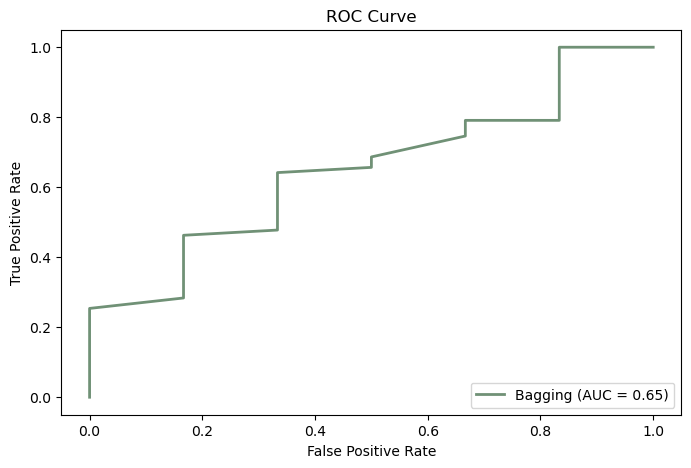

In [11]:
# ROC Curve
fpr_bag, tpr_bag, _ = roc_curve(y_test, bagging.predict_proba(X_test)[:, 1])
roc_auc_bagging = auc(fpr_bag, tpr_bag)

plt.figure(figsize=(8, 5))

plt.plot(fpr_bag, tpr_bag, color='#709176', lw=2, label=f'Bagging (AUC = {roc_auc_bagging:.2f})')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.show()

Now how does the ROC curve look? How does this compare to our classification accuracy metric?  What might be going on? 

*The ROC curve looks a little strange as it is not a true curve and slightly erratic looking. The model's AUC is also not very good at 0.65, which is slightly higher than an AUC of 0.5 which would indicate a random guess. Out accuracy metric of 0.918, on the other hand, indicates out model is performing quite well. This may be caused by an imbalanced dataset.*

### Step 6: Introducing upsampling

The ROC curve indicates that our model is not performing well.  This is a common issue in imbalanced datasets, where one class significantly outnumbers the other. To improve our model’s ability to correctly classify both groups, we will upsample the minority class so that both classes have equal representation in the training set.

**Perform upsampling to balance the dataset**
1. Separate the majority and minority classes:
- Identify which class (0,1) is underrepresented (the minority class) and which is overrepresented (the majority class). 
- Separate both the `X_train` data and `y_train` data into all majority class and all minority class sets. 
2. Apply upsampling:
- Use `resample()` to create additional synthetic samples of the minority class *with replacement* until it is the same size as the majority class data. Use a random state of 808. 
3. Combine the balanced classes:
Merge the original majority class with the newly upsampled minority class.
4. Shuffle the resampled dataset:
- Randomly shuffle the data to ensure the model does not learn any unintended patterns from the order of the data. Use a random state of 808 for shuffling both the resampled X and y training data. 
5. Print the value counts for the resampled y training data to ensure that the data is balanced. 


In [12]:
# Separate majority and minority classes
concat = pd.concat([X_train, y_train], axis=1)
print(f"Original value counts:\n {concat['Subarid'].value_counts()}")
minority = concat[(concat['Subarid'] == 0)]
majority = concat[(concat['Subarid'] == 1)]

# Upsample the minority class
minority_resampled = resample(minority, 
                              replace=True,       
                              n_samples=majority.shape[0],  
                              random_state=808)  

# Combine majority and upsampled minority class
balanced_train_data = pd.concat([majority, minority_resampled], axis = 0)

# Shuffle the dataset
shuffled_train_data = balanced_train_data.sample(frac = 1)
X_upsampled = shuffled_train_data.drop(columns=['Subarid'])
y_upsampled = shuffled_train_data['Subarid']

# Print value counts 
print(f"Upsampled value counts:\n {y_upsampled.value_counts()}")

Original value counts:
 Subarid
1    150
0     19
Name: count, dtype: int64
Upsampled value counts:
 Subarid
0    150
1    150
Name: count, dtype: int64


### Step 7: Retrain and evaluate model using balanced data

Now that we have addressed the class imbalance by upsampling the minority class, we will retrain the bagging classifier on the newly balanced dataset and evaluate its performance. This will help us determine whether handling class imbalance improves model accuracy and its ability to distinguish between classes. Create a bagging model using your balanced data. Use a random state of 808. Print the accuracy and and ROC Curve for this new model with balanced data. 

The model OOB score: 0.933
Model accuracy: 0.877


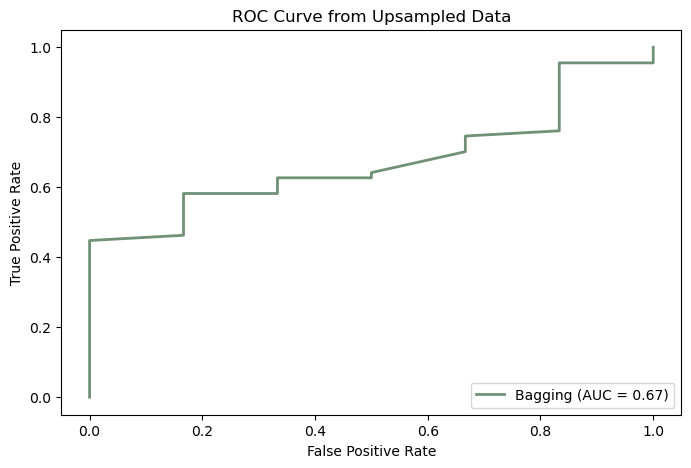

In [13]:
# Train a Bagging Ensemble of Decision Trees
bagging_up = BaggingClassifier(estimator = DecisionTreeClassifier(),
                            n_estimators = 100, # Number of trees
                            oob_score = True,
                            bootstrap = True,
                            random_state = 808)

# Fit model with upsampled data
bagging_up.fit(X_upsampled, y_upsampled)

# Generate predictions
bagging_pred_y_up = bagging_up.predict(X_test)

# Out-of-Bag (OOB) Score
oob_score_up = bagging_up.oob_score_

# Model accuracy
accuracy_up = accuracy_score(y_test, bagging_pred_y_up)

print(f"The model OOB score: {oob_score_up:.3f}")
print(f"Model accuracy: {accuracy_up:.3f}")

# ROC Curve
fpr_up, tpr_up, _ = roc_curve(y_test, bagging_up.predict_proba(X_test)[:, 1])
roc_auc_up = auc(fpr_up, tpr_up)

plt.figure(figsize=(8, 5))

plt.plot(fpr_up, tpr_up, color='#709176', lw=2, label=f'Bagging (AUC = {roc_auc_up:.2f})')

plt.title('ROC Curve from Upsampled Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.show()

How did this second model, trained on balanced data, do in comparison to the first on the accuracy and AUC metrics.  How should we interpret those results?  Did the upscaling prove useful?

*The second model, trained on balance data, had a lower accuracy score compared to the first model, not trained on balanced data. In addition, the AUC score of the second model was not much better than the AUC score of the first model, and only moderately increased. In this instance, upscaling did not prove useful as the resulting classifications were less accurate and did not increase the AUC significantly.*

### Step 8: Analyzing feature importance with permutation importance

Understanding which bird traits contribute the most to our model’s predictions is crucial for interpreting results. We covered in lecture how the results of ensemble methods are harder to interpret than a single decision tree.  But we do have some tools to do it.  In this step, we will compute permutation importance, which measures the impact of each trait by shuffling its values and observing the effect on model performance. This will help us identify which functional traits—such as diet, body mass, or habitat breadth—play the biggest role in predicting whether a species is found in a subarid environment.

Use `permutation_importance()` to calculate the importance values.  You'll need to pass it the model, the feature and target test data, and an n_repeats value of 10.

In [14]:
# Calculate importance values
importance = permutation_importance(bagging, X_test, y_test, n_repeats = 10, random_state=808)

# Importance values
importance_values = importance.importances_mean  

# Combine with feature names
importance_df = pd.DataFrame({
    'Feature': X_test.columns,  
    'Importance': importance_values
})

# Sort by importance value
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

               Feature  Importance
13      IncubationTime    0.019178
15           EggLength    0.015068
14          ClutchSize    0.005479
19        MaxLongevity    0.004110
16            EggWidth    0.001370
12     MigratoryStatus    0.000000
2   Diet_Invertebrates    0.000000
3     Diet_Vertebrates    0.000000
7          Diet_Plants    0.000000
4          Diet_Fruits    0.000000
6           Diet_Seeds    0.000000
5         Diet_Flowers    0.000000
18        NestingHabit    0.000000
8           Diet_Other    0.000000
0        AdultBodyMass   -0.001370
9         TrophicLevel   -0.001370
10       ActivityCycle   -0.002740
1          DietBreadth   -0.009589
11     ForagingStratum   -0.009589
17             EggMass   -0.013699


What features are most important in our model of species distribution?

*The most important features in our model of species distribtution are `IncubationTime` and `EggLength`.*